In [1]:
# Biggest Loser CHN Edition - Weight Loss Tracker
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [2]:
# Load or Create Sample Data
def create_sample_data():
    """Create sample data for demonstration purposes"""
    np.random.seed(42)
    
    participants = [
        {'id': 1, 'name': 'Fetso Sami', 'height': 179, 'start_weight': 95.55, 'target_weight': 87.9},
        {'id': 2, 'name': 'Faty Alper', 'height': 175, 'start_weight': 80.6, 'target_weight': 75.0},
        {'id': 3, 'name': 'Biggi Deger', 'height': 180, 'start_weight': 90.6, 'target_weight': 84.0},
    ]
    
    data = []
    # Program dates
    start_date = datetime(2025, 10, 27)
    end_date = datetime(2025, 12, 22)
    
    # Calculate number of weeks in the program
    program_weeks = int((end_date - start_date).days / 7) + 1
    
    print(f"Program Period: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
    print(f"Generating {program_weeks} weeks of data...")
    
    for participant in participants:
        weight = participant['start_weight']
        # Generate data for the entire program duration
        for week in range(program_weeks):
            date = start_date + timedelta(weeks=week)
            # Don't generate data beyond end_date
            if date > end_date:
                break
                
            # Random weight loss between 0.5-2 kg per week
            if week > 0:
                weight -= np.random.uniform(0.5, 2.0)
            
            data.append({
                'participant_id': participant['id'],
                'name': participant['name'],
                'date': date.strftime('%Y-%m-%d'),
                'weight_kg': round(weight, 1),
                'height_cm': participant['height'],
                'weekly_weight_change_kg': None,
                'total_weight_loss_kg': None,
                'target_weight': participant['target_weight'],  # Individual target weight
                'notes': f'Week {week + 1}' if week % 2 == 0 else ''
            })
    
    return pd.DataFrame(data)

# Try to load existing data
try:
    df = pd.read_csv('looser_data.csv')
    if len(df) == 0:
        print("CSV file is empty. Creating sample data...")
        df = create_sample_data()
        df.to_csv('looser_data.csv', index=False)
        print("✓ Sample data created and saved to looser_data.csv")
    else:
        print(f"✓ Loaded {len(df)} records from looser_data.csv")
except Exception as e:
    print(f"Error loading data: {e}")
    print("Creating sample data...")
    df = create_sample_data()
    df.to_csv('looser_data.csv', index=False)
    print("✓ Sample data created and saved")

# Display basic info
print(f"\nDataset shape: {df.shape}")
print(f"Participants: {df['name'].nunique()}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

✓ Loaded 9 records from looser_data.csv

Dataset shape: (9, 12)
Participants: 3
Date range: 10/27/25 to 11/3/25


In [3]:
# Display Data Structure and Sample Records
print("=" * 60)
print("DATA OVERVIEW")
print("=" * 60)

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Display column info
print("\nColumn Information:")
print(df.dtypes)

print("\n" + "=" * 60)
print("SAMPLE RECORDS (First 10)")
print("=" * 60)
df.head(10)

DATA OVERVIEW

Column Information:
participant_id                      int64
name                               object
date                       datetime64[ns]
weight_kg                         float64
height_cm                           int64
weekly_weight_change_kg           float64
total_weight_loss_kg              float64
target_weight                     float64
notes                              object
weight_to_target_kg               float64
goal_weight_loss_kg               float64
progress_to_goal_pct              float64
dtype: object

SAMPLE RECORDS (First 10)


,participant_id,name,date,weight_kg,height_cm,weekly_weight_change_kg,total_weight_loss_kg,target_weight,notes,weight_to_target_kg,goal_weight_loss_kg,progress_to_goal_pct
0,1,Fetso Sami,2025-10-27,95.55,179,NaN,0.00,87.9,Week 1,7.65,7.65,0.0
1,1,Fetso Sami,2025-11-03,94.25,179,-1.30,-1.30,87.9,Week 2,6.35,7.65,17.0
2,1,Fetso Sami,2025-11-10,94.55,179,-2.95,-4.25,87.9,Week 3,3.40,7.65,55.6
3,2,Faty Alper,2025-10-27,80.60,175,NaN,0.00,75.0,Week 1,5.60,5.60,0.0
4,2,Faty Alper,2025-11-03,80.60,175,0.00,0.00,75.0,Week 2,5.60,5.60,0.0
5,2,Faty Alper,2025-11-10,81.30,175,0.00,0.00,75.0,Week 3,5.60,5.60,0.0
6,3,Biggi Deger,2025-10-27,90.60,180,NaN,0.00,84.0,Week 1,6.60,6.60,0.0
7,3,Biggi Deger,2025-11-03,90.10,180,-0.50,-0.50,84.0,Week 2,6.10,6.60,7.6
8,3,Biggi Deger,2025-11-10,87.45,180,-2.65,-3.15,84.0,Week 3,3.45,6.60,47.7


In [4]:
# Calculate Weekly Weight Changes and Total Weight Loss
print("=" * 60)
print("CALCULATING METRICS")
print("=" * 60)

# Sort by participant and date
df = df.sort_values(['participant_id', 'date']).reset_index(drop=True)

# Calculate weekly weight change (difference from previous week)
df['weekly_weight_change_kg'] = df.groupby('participant_id')['weight_kg'].diff()

# Calculate total weight loss from baseline (starting weight)
df['total_weight_loss_kg'] = df.groupby('participant_id')['weight_kg'].transform(
    lambda x: x - x.iloc[0]
)

# Calculate progress toward goal
df['weight_to_target_kg'] = df['weight_kg'] - df['target_weight']
df['goal_weight_loss_kg'] = df.groupby('participant_id')['weight_kg'].transform(
    lambda x: x.iloc[0]
) - df['target_weight']
df['progress_to_goal_pct'] = (
    df['total_weight_loss_kg'].abs() / df['goal_weight_loss_kg'].abs() * 100
).round(1)

# Save updated data back to CSV
df.to_csv('looser_data.csv', index=False)

print("✓ Calculated weekly_weight_change_kg")
print("✓ Calculated total_weight_loss_kg")
print("✓ Calculated weight_to_target_kg (remaining weight to lose)")
print("✓ Calculated progress_to_goal_pct (% of goal achieved)")
print("✓ Data saved to looser_data.csv")

print("\n" + "=" * 60)
print("UPDATED DATA (Sample)")
print("=" * 60)
df[['name', 'date', 'weight_kg', 'target_weight', 'weight_to_target_kg', 'progress_to_goal_pct']].head(12)

CALCULATING METRICS
✓ Calculated weekly_weight_change_kg
✓ Calculated total_weight_loss_kg
✓ Calculated weight_to_target_kg (remaining weight to lose)
✓ Calculated progress_to_goal_pct (% of goal achieved)
✓ Data saved to looser_data.csv

UPDATED DATA (Sample)


,name,date,weight_kg,target_weight,weight_to_target_kg,progress_to_goal_pct
0,Fetso Sami,2025-10-27,95.55,87.9,7.65,0.0
1,Fetso Sami,2025-11-03,94.25,87.9,6.35,17.0
2,Fetso Sami,2025-11-10,94.55,87.9,6.65,13.1
3,Faty Alper,2025-10-27,80.60,75.0,5.60,0.0
4,Faty Alper,2025-11-03,80.60,75.0,5.60,0.0
5,Faty Alper,2025-11-10,81.30,75.0,6.30,12.5
6,Biggi Deger,2025-10-27,90.60,84.0,6.60,0.0
7,Biggi Deger,2025-11-03,90.10,84.0,6.10,7.6
8,Biggi Deger,2025-11-10,87.45,84.0,3.45,47.7


INDIVIDUAL WEIGHT LOSS PROGRESS


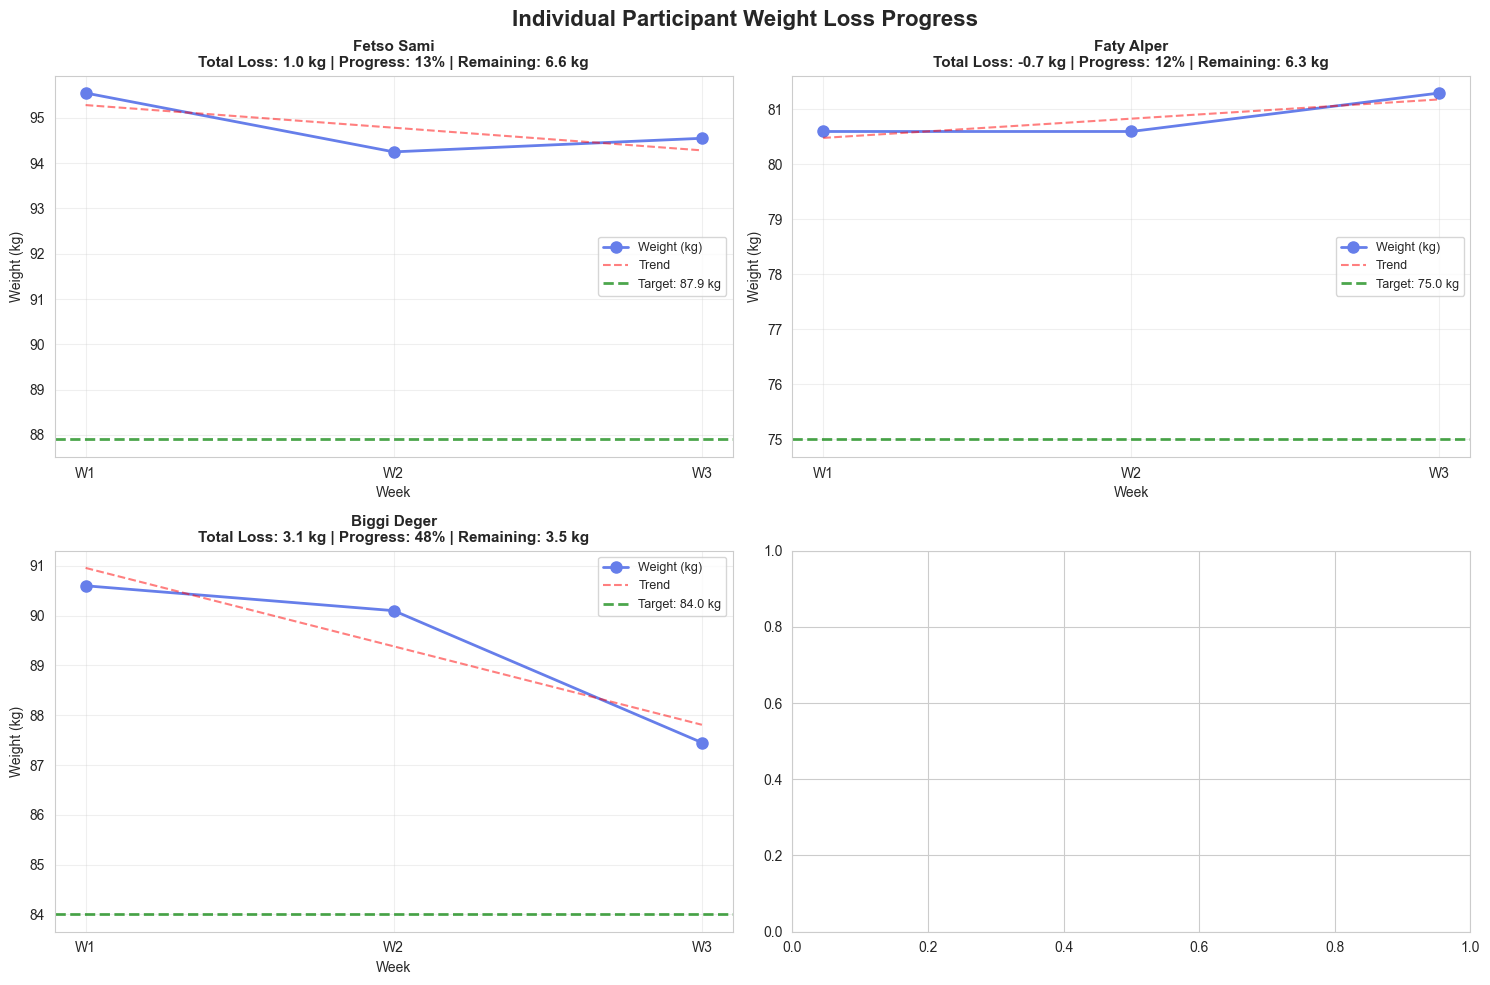

✓ Individual progress charts generated with target weight lines


In [5]:
# Individual Progress Visualization
print("=" * 60)
print("INDIVIDUAL WEIGHT LOSS PROGRESS")
print("=" * 60)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Individual Participant Weight Loss Progress', fontsize=16, fontweight='bold')

participants = df['name'].unique()

for idx, participant in enumerate(participants):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    participant_data = df[df['name'] == participant].copy()
    
    # Calculate week numbers from the start date
    participant_data['week_number'] = ((participant_data['date'] - participant_data['date'].min()).dt.days / 7).astype(int) + 1
    
    # Plot weight over time using week numbers
    ax.plot(participant_data['week_number'], participant_data['weight_kg'], 
            marker='o', linewidth=2, markersize=8, label='Weight (kg)', color='#667eea')
    
    # Add trend line
    z = np.polyfit(participant_data['week_number'], participant_data['weight_kg'], 1)
    p = np.poly1d(z)
    ax.plot(participant_data['week_number'], p(participant_data['week_number']), 
            '--', alpha=0.5, color='red', label='Trend')
    
    # Add target weight line
    target_weight = participant_data['target_weight'].iloc[0]
    ax.axhline(y=target_weight, color='green', linestyle='--', linewidth=2, 
               alpha=0.7, label=f'Target: {target_weight} kg')
    
    # Calculate stats
    start_weight = participant_data['weight_kg'].iloc[0]
    current_weight = participant_data['weight_kg'].iloc[-1]
    total_loss = start_weight - current_weight
    progress_pct = participant_data['progress_to_goal_pct'].iloc[-1]
    remaining = current_weight - target_weight
    
    title = f'{participant}\nTotal Loss: {total_loss:.1f} kg | Progress: {progress_pct:.0f}%'
    if remaining > 0:
        title += f' | Remaining: {remaining:.1f} kg'
    else:
        title += ' | Goal Achieved! 🎉'
    
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xlabel('Week')
    ax.set_ylabel('Weight (kg)')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Set x-axis to show integer week numbers
    ax.set_xticks(participant_data['week_number'])
    ax.set_xticklabels([f'W{w}' for w in participant_data['week_number']])

plt.tight_layout()
plt.show()

print("✓ Individual progress charts generated with target weight lines")

PARTICIPANT COMPARISONS


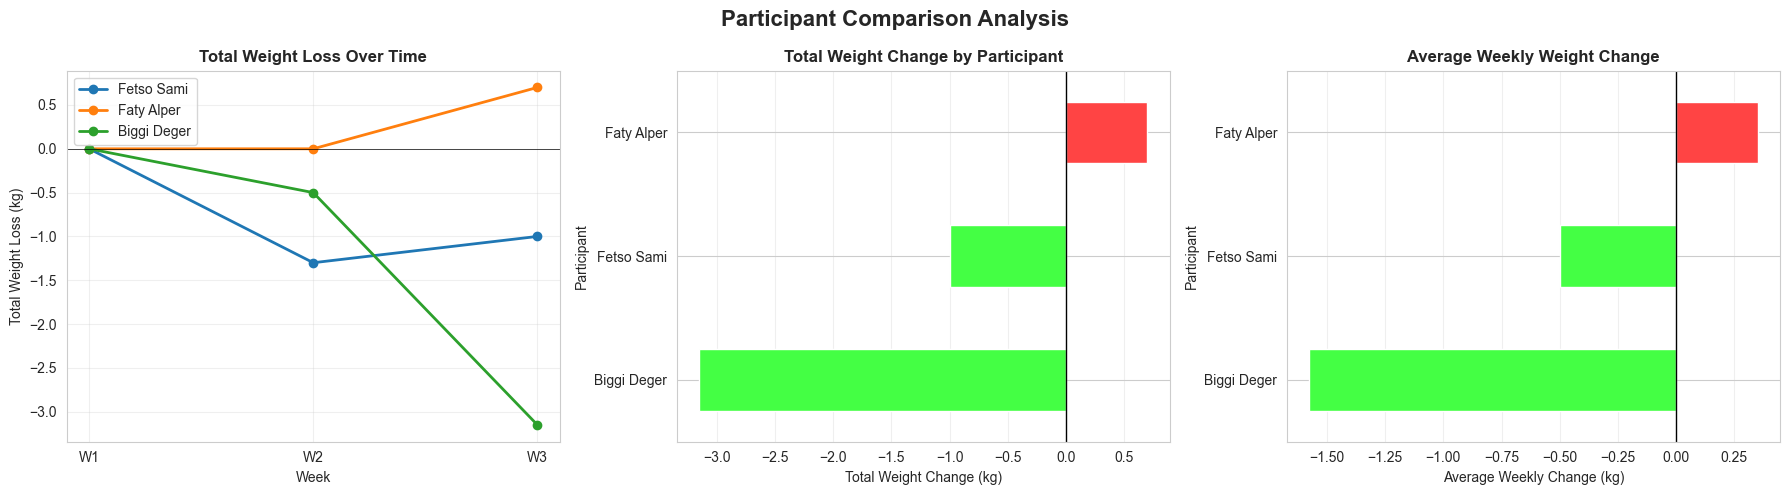

✓ Comparison visualizations generated
✓ 'Total Weight Loss Over Time' now displays weeks (W1, W2, ...) on x-axis


In [6]:
# Participant Comparison Visualizations
print("=" * 60)
print("PARTICIPANT COMPARISONS")
print("=" * 60)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Participant Comparison Analysis', fontsize=16, fontweight='bold')

# 1. Total Weight Loss Comparison (Line Chart) - using weeks
ax1 = axes[0]
# Calculate week numbers for all data
df_temp = df.copy()
df_temp['week_number'] = ((df_temp['date'] - df_temp['date'].min()).dt.days / 7).astype(int) + 1

for participant in df_temp['name'].unique():
    participant_data = df_temp[df_temp['name'] == participant]
    ax1.plot(participant_data['week_number'], participant_data['total_weight_loss_kg'], 
            marker='o', linewidth=2, label=participant)
ax1.set_title('Total Weight Loss Over Time', fontsize=12, fontweight='bold')
ax1.set_xlabel('Week')
ax1.set_ylabel('Total Weight Loss (kg)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Set x-axis to show integer week numbers
all_weeks = sorted(df_temp['week_number'].unique())
ax1.set_xticks(all_weeks)
ax1.set_xticklabels([f'W{w}' for w in all_weeks])

# 2. Total Weight Change Comparison (Bar Chart)
ax2 = axes[1]
latest_data = df.groupby('name')['total_weight_loss_kg'].last().sort_values()
colors = ['#ff4444' if x > 0 else '#44ff44' for x in latest_data.values]
latest_data.plot(kind='barh', ax=ax2, color=colors)
ax2.set_title('Total Weight Change by Participant', fontsize=12, fontweight='bold')
ax2.set_xlabel('Total Weight Change (kg)')
ax2.set_ylabel('Participant')
ax2.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax2.grid(True, alpha=0.3, axis='x')

# 3. Weight Loss Rate Comparison
ax3 = axes[2]
weekly_avg = df[df['weekly_weight_change_kg'].notna()].groupby('name')['weekly_weight_change_kg'].mean().sort_values()
colors = ['#ff4444' if x > 0 else '#44ff44' for x in weekly_avg.values]
weekly_avg.plot(kind='barh', ax=ax3, color=colors)
ax3.set_title('Average Weekly Weight Change', fontsize=12, fontweight='bold')
ax3.set_xlabel('Average Weekly Change (kg)')
ax3.set_ylabel('Participant')
ax3.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax3.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("✓ Comparison visualizations generated")
print("✓ 'Total Weight Loss Over Time' now displays weeks (W1, W2, ...) on x-axis")

In [7]:
# Summary Statistics and Insights
print("=" * 80)
print("SUMMARY STATISTICS & INSIGHTS")
print("=" * 80)

# Program dates
start_date = datetime(2025, 10, 25)
end_date = datetime(2025, 12, 22)
program_duration_days = (end_date - start_date).days
program_duration_weeks = program_duration_days / 7

# Overall statistics
print("\n📅 PROGRAM INFORMATION")
print("-" * 80)
print(f"Start Date: {start_date.strftime('%B %d, %Y')}")
print(f"End Date: {end_date.strftime('%B %d, %Y')}")
print(f"Program Duration: {program_duration_weeks:.1f} weeks ({program_duration_days} days)")

print("\n📊 OVERALL PROGRAM STATISTICS")
print("-" * 80)
total_participants = df['participant_id'].nunique()
total_measurements = len(df)
date_range = (df['date'].max() - df['date'].min()).days / 7
print(f"Total Participants: {total_participants}")
print(f"Total Measurements: {total_measurements}")
print(f"Weeks with Data: {date_range:.1f} weeks")

# Per-participant summary
print("\n👥 PARTICIPANT SUMMARY")
print("-" * 80)

summary_stats = []
for participant in df['name'].unique():
    p_data = df[df['name'] == participant].copy()
    
    start_weight = p_data['weight_kg'].iloc[0]
    current_weight = p_data['weight_kg'].iloc[-1]
    target_weight = p_data['target_weight'].iloc[0]
    total_loss = start_weight - current_weight
    percent_loss = (total_loss / start_weight) * 100
    avg_weekly_loss = p_data[p_data['weekly_weight_change_kg'].notna()]['weekly_weight_change_kg'].mean()
    remaining = current_weight - target_weight
    progress_pct = p_data['progress_to_goal_pct'].iloc[-1]
    
    summary_stats.append({
        'Name': participant,
        'Start (kg)': f"{start_weight:.1f}",
        'Current (kg)': f"{current_weight:.1f}",
        'Target (kg)': f"{target_weight:.1f}",
        'Lost (kg)': f"{total_loss:.1f}",
        'Remaining (kg)': f"{remaining:.1f}" if remaining > 0 else "Goal!",
        'Progress %': f"{progress_pct:.0f}%",
        'Avg Weekly (kg)': f"{avg_weekly_loss:.2f}"
    })

summary_df = pd.DataFrame(summary_stats)
print(summary_df.to_string(index=False))

# Find the winner (most weight lost)
print("\n🏆 LEADERBOARD - Total Weight Loss")
print("-" * 80)
leaderboard = df.groupby('name').agg({
    'weight_kg': ['first', 'last'],
    'total_weight_loss_kg': 'last'
}).round(1)
leaderboard.columns = ['Start Weight', 'Current Weight', 'Total Loss']
leaderboard['Total Loss'] = leaderboard['Start Weight'] - leaderboard['Current Weight']
leaderboard = leaderboard.sort_values('Total Loss', ascending=False)
print(leaderboard)

winner = leaderboard.index[0]
winner_loss = leaderboard['Total Loss'].iloc[0]
print(f"\n🎉 Most Weight Lost: {winner} with {winner_loss:.1f} kg!")

# Progress to goal leaderboard
print("\n🎯 LEADERBOARD - Progress to Goal")
print("-" * 80)
goal_progress = df.groupby('name').last()[['progress_to_goal_pct', 'weight_to_target_kg']].round(1)
goal_progress = goal_progress.sort_values('progress_to_goal_pct', ascending=False)
goal_progress.columns = ['Progress %', 'Remaining (kg)']
print(goal_progress)

goal_leader = goal_progress.index[0]
goal_progress_pct = goal_progress['Progress %'].iloc[0]
print(f"\n🌟 Closest to Goal: {goal_leader} at {goal_progress_pct:.0f}% progress!")

print("\n" + "=" * 80)
print("📈 Analysis complete! Keep up the great work!")
print("=" * 80)

SUMMARY STATISTICS & INSIGHTS

📅 PROGRAM INFORMATION
--------------------------------------------------------------------------------
Start Date: October 25, 2025
End Date: December 22, 2025
Program Duration: 8.3 weeks (58 days)

📊 OVERALL PROGRAM STATISTICS
--------------------------------------------------------------------------------
Total Participants: 3
Total Measurements: 9
Weeks with Data: 2.0 weeks

👥 PARTICIPANT SUMMARY
--------------------------------------------------------------------------------
       Name Start (kg) Current (kg) Target (kg) Lost (kg) Remaining (kg) Progress % Avg Weekly (kg)
 Fetso Sami       95.5         94.5        87.9       1.0            6.6        13%           -0.50
 Faty Alper       80.6         81.3        75.0      -0.7            6.3        12%            0.35
Biggi Deger       90.6         87.5        84.0       3.1            3.5        48%           -1.57

🏆 LEADERBOARD - Total Weight Loss
--------------------------------------------------

In [8]:
# Generate HTML Dashboard Report
import io
import base64
from datetime import datetime

print("=" * 80)
print("GENERATING HTML DASHBOARD")
print("=" * 80)

def fig_to_base64(fig):
    """Convert matplotlib figure to base64 string"""
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', dpi=100)
    buf.seek(0)
    img_base64 = base64.b64encode(buf.read()).decode('utf-8')
    buf.close()
    return img_base64

# Generate Individual Progress Chart with Target Lines
fig1, axes = plt.subplots(2, 2, figsize=(15, 10))
fig1.suptitle('Individual Participant Weight Loss Progress', fontsize=16, fontweight='bold')

participants = df['name'].unique()
for idx, participant in enumerate(participants):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    participant_data = df[df['name'] == participant].copy()
    
    # Calculate week numbers from the start date
    participant_data['week_number'] = ((participant_data['date'] - participant_data['date'].min()).dt.days / 7).astype(int) + 1
    
    # Plot weight over time using week numbers
    ax.plot(participant_data['week_number'], participant_data['weight_kg'], 
            marker='o', linewidth=2, markersize=8, label='Weight (kg)', color='#667eea')
    
    # Add trend line
    z = np.polyfit(participant_data['week_number'], participant_data['weight_kg'], 1)
    p = np.poly1d(z)
    ax.plot(participant_data['week_number'], p(participant_data['week_number']), 
            '--', alpha=0.5, color='red', label='Trend')
    
    # Add target weight line
    target_weight = participant_data['target_weight'].iloc[0]
    ax.axhline(y=target_weight, color='green', linestyle='--', linewidth=2, 
               alpha=0.7, label=f'Target: {target_weight} kg')
    
    # Calculate stats
    start_weight = participant_data['weight_kg'].iloc[0]
    current_weight = participant_data['weight_kg'].iloc[-1]
    total_loss = start_weight - current_weight
    progress_pct = participant_data['progress_to_goal_pct'].iloc[-1]
    remaining = current_weight - target_weight
    
    title = f'{participant}\nTotal Loss: {total_loss:.1f} kg | Progress: {progress_pct:.0f}%'
    if remaining > 0:
        title += f' | Remaining: {remaining:.1f} kg'
    else:
        title += ' | Goal Achieved!'
    
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xlabel('Week')
    ax.set_ylabel('Weight (kg)')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Set x-axis to show integer week numbers
    ax.set_xticks(participant_data['week_number'])
    ax.set_xticklabels([f'W{w}' for w in participant_data['week_number']])

plt.tight_layout()
individual_chart = fig_to_base64(fig1)
plt.close(fig1)

# Generate Comparison Charts
fig2, axes = plt.subplots(1, 3, figsize=(18, 5))
fig2.suptitle('Participant Comparison Analysis', fontsize=16, fontweight='bold')

# 1. Total Weight Loss Comparison (Line Chart) - using weeks
ax1 = axes[0]
df_temp = df.copy()
df_temp['week_number'] = ((df_temp['date'] - df_temp['date'].min()).dt.days / 7).astype(int) + 1

for participant in df_temp['name'].unique():
    participant_data = df_temp[df_temp['name'] == participant]
    ax1.plot(participant_data['week_number'], participant_data['total_weight_loss_kg'], 
            marker='o', linewidth=2, label=participant)
ax1.set_title('Total Weight Loss Over Time', fontsize=12, fontweight='bold')
ax1.set_xlabel('Week')
ax1.set_ylabel('Total Weight Loss (kg)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Set x-axis to show integer week numbers
all_weeks = sorted(df_temp['week_number'].unique())
ax1.set_xticks(all_weeks)
ax1.set_xticklabels([f'W{w}' for w in all_weeks])

# 2. Total Weight Change Comparison (Bar Chart)
ax2 = axes[1]
latest_data = df.groupby('name')['total_weight_loss_kg'].last().sort_values()
colors = ['#ff4444' if x > 0 else '#44ff44' for x in latest_data.values]
latest_data.plot(kind='barh', ax=ax2, color=colors)
ax2.set_title('Total Weight Change by Participant', fontsize=12, fontweight='bold')
ax2.set_xlabel('Total Weight Change (kg)')
ax2.set_ylabel('Participant')
ax2.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax2.grid(True, alpha=0.3, axis='x')

# 3. Progress to Goal Comparison
ax3 = axes[2]
progress_data = df.groupby('name')['progress_to_goal_pct'].last().sort_values(ascending=False)
colors = ['#44ff44' if x >= 100 else '#667eea' for x in progress_data.values]
progress_data.plot(kind='barh', ax=ax3, color=colors)
ax3.set_title('Progress to Goal (%)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Progress (%)')
ax3.set_ylabel('Participant')
ax3.axvline(x=100, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Goal')
ax3.grid(True, alpha=0.3, axis='x')
ax3.legend()

plt.tight_layout()
comparison_chart = fig_to_base64(fig2)
plt.close(fig2)

print("✓ Charts generated and encoded with target weight information")
print("✓ Individual progress charts now display weeks (W1, W2, ...) on x-axis")
print("✓ Total Weight Loss Over Time chart now displays weeks on x-axis")

GENERATING HTML DASHBOARD
✓ Charts generated and encoded with target weight information
✓ Individual progress charts now display weeks (W1, W2, ...) on x-axis
✓ Total Weight Loss Over Time chart now displays weeks on x-axis


In [9]:
# Build HTML Dashboard
# Program dates
start_date = datetime(2025, 10, 25)
end_date = datetime(2025, 12, 22)
program_duration_days = (end_date - start_date).days
program_duration_weeks = program_duration_days / 7

# Calculate statistics for the report
total_participants = df['participant_id'].nunique()
total_measurements = len(df)
date_range = (df['date'].max() - df['date'].min()).days / 7

# Build participant summary table with target weight
summary_rows = ""
for participant in df['name'].unique():
    p_data = df[df['name'] == participant].copy()
    start_weight = p_data['weight_kg'].iloc[0]
    current_weight = p_data['weight_kg'].iloc[-1]
    target_weight = p_data['target_weight'].iloc[0]
    total_loss = start_weight - current_weight
    percent_loss = (total_loss / start_weight) * 100
    avg_weekly = p_data[p_data['weekly_weight_change_kg'].notna()]['weekly_weight_change_kg'].mean()
    remaining = current_weight - target_weight
    progress_pct = p_data['progress_to_goal_pct'].iloc[-1]
    
    remaining_display = f'{remaining:.1f}' if remaining > 0 else '<span style="color: #28a745; font-weight: bold;">Goal!</span>'
    
    summary_rows += f"""
        <tr>
            <td>{participant}</td>
            <td>{start_weight:.1f}</td>
            <td>{current_weight:.1f}</td>
            <td style="color: #28a745; font-weight: bold;">{target_weight:.1f}</td>
            <td class="weight-loss">{total_loss:.1f}</td>
            <td>{remaining_display}</td>
            <td style="font-weight: bold;">{progress_pct:.0f}%</td>
            <td>{avg_weekly:.2f}</td>
        </tr>
    """

# Build leaderboard
leaderboard = df.groupby('name').agg({
    'weight_kg': ['first', 'last']
}).round(1)
leaderboard['total_loss'] = leaderboard['weight_kg']['first'] - leaderboard['weight_kg']['last']
leaderboard = leaderboard.sort_values(('total_loss', ''), ascending=False)

leaderboard_rows = ""
for idx, (name, row) in enumerate(leaderboard.iterrows()):
    medal = "🏆" if idx == 0 else "🥈" if idx == 1 else "🥉" if idx == 2 else ""
    highlight = ' class="winner"' if idx == 0 else ''
    start_wt = float(row['weight_kg']['first'])
    last_wt = float(row['weight_kg']['last'])
    total_loss_val = float(row[('total_loss', '')])
    leaderboard_rows += f"""
        <tr{highlight}>
            <td>{idx + 1}</td>
            <td>{medal} {name}</td>
            <td>{start_wt:.1f}</td>
            <td>{last_wt:.1f}</td>
            <td class="weight-loss">{total_loss_val:.1f}</td>
        </tr>
    """

# Build goal progress leaderboard
goal_progress = df.groupby('name').last()[['progress_to_goal_pct', 'weight_to_target_kg', 'target_weight']].round(1)
goal_progress = goal_progress.sort_values('progress_to_goal_pct', ascending=False)

goal_leaderboard_rows = ""
for idx, (name, row) in enumerate(goal_progress.iterrows()):
    medal = "🎯" if idx == 0 else "🥈" if idx == 1 else "🥉" if idx == 2 else ""
    highlight = ' class="winner"' if idx == 0 else ''
    progress = float(row['progress_to_goal_pct'])
    remaining = float(row['weight_to_target_kg'])
    target = float(row['target_weight'])
    
    remaining_display = f'{remaining:.1f} kg' if remaining > 0 else '<span style="color: #28a745; font-weight: bold;">Goal Achieved!</span>'
    progress_color = '#28a745' if progress >= 100 else '#667eea'
    
    goal_leaderboard_rows += f"""
        <tr{highlight}>
            <td>{idx + 1}</td>
            <td>{medal} {name}</td>
            <td>{target:.1f} kg</td>
            <td style="color: {progress_color}; font-weight: bold;">{progress:.0f}%</td>
            <td>{remaining_display}</td>
        </tr>
    """

winner = leaderboard.index[0]
winner_loss = float(leaderboard.iloc[0][('total_loss', '')])

goal_leader = goal_progress.index[0]
goal_progress_pct = float(goal_progress.iloc[0]['progress_to_goal_pct'])

print("✓ Statistics calculated with target weight information")
print(f"✓ Program Period: {start_date.strftime('%B %d, %Y')} - {end_date.strftime('%B %d, %Y')}")

✓ Statistics calculated with target weight information
✓ Program Period: October 25, 2025 - December 22, 2025


In [10]:
# Create HTML content
html_content = f"""
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Biggest Loser CHN Edition - Dashboard</title>
    <style>
        * {{
            margin: 0;
            padding: 0;
            box-sizing: border-box;
        }}
        
        body {{
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            padding: 20px;
            color: #333;
        }}
        
        .container {{
            max-width: 1400px;
            margin: 0 auto;
            background: white;
            border-radius: 15px;
            box-shadow: 0 10px 40px rgba(0,0,0,0.2);
            overflow: hidden;
        }}
        
        header {{
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            color: white;
            padding: 40px;
            text-align: center;
        }}
        
        header h1 {{
            font-size: 2.5em;
            margin-bottom: 10px;
        }}
        
        header p {{
            font-size: 1.1em;
            opacity: 0.9;
        }}
        
        .program-period {{
            background: rgba(255, 255, 255, 0.15);
            padding: 15px;
            border-radius: 10px;
            margin-top: 15px;
            font-size: 1.05em;
        }}
        
        .stats-grid {{
            display: grid;
            grid-template-columns: repeat(auto-fit, minmax(200px, 1fr));
            gap: 20px;
            padding: 40px;
            background: #f8f9fa;
        }}
        
        .stat-card {{
            background: white;
            padding: 25px;
            border-radius: 10px;
            box-shadow: 0 2px 10px rgba(0,0,0,0.1);
            text-align: center;
        }}
        
        .stat-card h3 {{
            color: #667eea;
            font-size: 0.9em;
            text-transform: uppercase;
            margin-bottom: 10px;
        }}
        
        .stat-card .value {{
            font-size: 2.5em;
            font-weight: bold;
            color: #333;
        }}
        
        .section {{
            padding: 40px;
        }}
        
        .section h2 {{
            color: #667eea;
            font-size: 1.8em;
            margin-bottom: 20px;
            padding-bottom: 10px;
            border-bottom: 3px solid #667eea;
        }}
        
        .chart-container {{
            margin: 30px 0;
            text-align: center;
        }}
        
        .chart-container img {{
            max-width: 100%;
            height: auto;
            border-radius: 10px;
            box-shadow: 0 4px 15px rgba(0,0,0,0.1);
        }}
        
        table {{
            width: 100%;
            border-collapse: collapse;
            margin: 20px 0;
            background: white;
            border-radius: 10px;
            overflow: hidden;
            box-shadow: 0 2px 10px rgba(0,0,0,0.1);
        }}
        
        th {{
            background: #667eea;
            color: white;
            padding: 15px;
            text-align: left;
            font-weight: 600;
        }}
        
        td {{
            padding: 12px 15px;
            border-bottom: 1px solid #eee;
        }}
        
        tr:hover {{
            background: #f8f9fa;
        }}
        
        .winner {{
            background: #fff3cd !important;
            font-weight: bold;
        }}
        
        .weight-loss {{
            color: #28a745;
            font-weight: bold;
        }}
        
        .highlight-box {{
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            color: white;
            padding: 30px;
            border-radius: 10px;
            margin: 30px 0;
            text-align: center;
        }}
        
        .highlight-box h3 {{
            font-size: 2em;
            margin-bottom: 10px;
        }}
        
        .highlight-box p {{
            font-size: 1.2em;
        }}
        
        .dual-highlight {{
            display: grid;
            grid-template-columns: 1fr 1fr;
            gap: 20px;
            margin: 30px 0;
        }}
        
        .dual-highlight .highlight-box {{
            margin: 0;
        }}
        
        footer {{
            background: #333;
            color: white;
            text-align: center;
            padding: 20px;
            font-size: 0.9em;
        }}
    </style>
</head>
<body>
    <div class="container">
        <header>
            <h1>🏋️ Biggest Loser CHN Edition</h1>
            <p>Weight Loss Tracking Dashboard</p>
            <div class="program-period">
                <strong>Program Period:</strong> {start_date.strftime('%B %d, %Y')} - {end_date.strftime('%B %d, %Y')}
                <br>
                <span style="font-size: 0.95em; opacity: 0.9;">({program_duration_weeks:.1f} weeks / {program_duration_days} days)</span>
            </div>
            <p style="font-size: 0.85em; margin-top: 15px; opacity: 0.8;">Last Updated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
        </header>
        
        <div class="stats-grid">
            <div class="stat-card">
                <h3>Participants</h3>
                <div class="value">{total_participants}</div>
            </div>
            <div class="stat-card">
                <h3>Total Measurements</h3>
                <div class="value">{total_measurements}</div>
            </div>
            <div class="stat-card">
                <h3>Weeks with Data</h3>
                <div class="value">{date_range:.0f}</div>
                <p style="margin-top: 5px; color: #666; font-size: 0.9em;">of {program_duration_weeks:.0f} total</p>
            </div>
            <div class="stat-card">
                <h3>Days Remaining</h3>
                <div class="value">{max(0, (end_date - datetime.now()).days)}</div>
                <p style="margin-top: 5px; color: #666; font-size: 0.9em;">until end date</p>
            </div>
        </div>
        
        <div class="section">
            <div class="dual-highlight">
                <div class="highlight-box">
                    <h3>🏆 Most Weight Lost</h3>
                    <p><strong>{winner}</strong> with <strong>{winner_loss:.1f} kg</strong> lost!</p>
                </div>
                <div class="highlight-box" style="background: linear-gradient(135deg, #28a745 0%, #20c997 100%);">
                    <h3>🎯 Closest to Goal</h3>
                    <p><strong>{goal_leader}</strong> at <strong>{goal_progress_pct:.0f}%</strong> progress!</p>
                </div>
            </div>
        </div>
        
        <div class="section">
            <h2>🏆 Leaderboard - Total Weight Loss</h2>
            <table>
                <thead>
                    <tr>
                        <th>Rank</th>
                        <th>Name</th>
                        <th>Start Weight (kg)</th>
                        <th>Current Weight (kg)</th>
                        <th>Total Loss (kg)</th>
                    </tr>
                </thead>
                <tbody>
                    {leaderboard_rows}
                </tbody>
            </table>
        </div>
        
        <div class="section">
            <h2>🎯 Leaderboard - Progress to Goal</h2>
            <table>
                <thead>
                    <tr>
                        <th>Rank</th>
                        <th>Name</th>
                        <th>Target Weight</th>
                        <th>Progress to Goal</th>
                        <th>Remaining</th>
                    </tr>
                </thead>
                <tbody>
                    {goal_leaderboard_rows}
                </tbody>
            </table>
        </div>
        
        <div class="section">
            <h2>👥 Participant Summary</h2>
            <table>
                <thead>
                    <tr>
                        <th>Name</th>
                        <th>Start (kg)</th>
                        <th>Current (kg)</th>
                        <th>Target (kg)</th>
                        <th>Lost (kg)</th>
                        <th>Remaining (kg)</th>
                        <th>Progress %</th>
                        <th>Avg Weekly (kg)</th>
                    </tr>
                </thead>
                <tbody>
                    {summary_rows}
                </tbody>
            </table>
        </div>
        
        <div class="section">
            <h2>📈 Individual Progress</h2>
            <p style="margin-bottom: 20px; color: #666;">Green dashed line indicates target weight goal</p>
            <div class="chart-container">
                <img src="data:image/png;base64,{individual_chart}" alt="Individual Progress Charts">
            </div>
        </div>
        
        <div class="section">
            <h2>🔄 Participant Comparisons</h2>
            <div class="chart-container">
                <img src="data:image/png;base64,{comparison_chart}" alt="Comparison Charts">
            </div>
        </div>
        
        <footer>
            <p>Biggest Loser CHN Edition - Weight Loss Tracking System</p>
            <p style="margin-top: 5px; opacity: 0.8;">Program: {start_date.strftime('%b %d, %Y')} - {end_date.strftime('%b %d, %Y')} | Keep up the great work! 💪</p>
        </footer>
    </div>
</body>
</html>
"""

# Write to file
output_file = "index.html"
with open(output_file, 'w', encoding='utf-8') as f:
    f.write(html_content)

print(f"✓ HTML dashboard created: {output_file}")
print(f"✓ File size: {len(html_content) / 1024:.1f} KB")
print(f"✓ Program Period: {start_date.strftime('%B %d, %Y')} - {end_date.strftime('%B %d, %Y')}")
print(f"\\n🌐 Open '{output_file}' in your web browser to view the dashboard!")
print(f"\\n📍 GitHub Pages URL: https://deye.github.io/BiggestLooserChnEdition/")
print("=" * 80)

✓ HTML dashboard created: index.html
✓ File size: 223.1 KB
✓ Program Period: October 25, 2025 - December 22, 2025
\n🌐 Open 'index.html' in your web browser to view the dashboard!
\n📍 GitHub Pages URL: https://deye.github.io/BiggestLooserChnEdition/
